In [1]:
import cv2
import numpy as np
import math
from collections import defaultdict
from PIL import Image,ImageDraw
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import face_recognition  # install from https://github.com/ageitgey/face_recognition

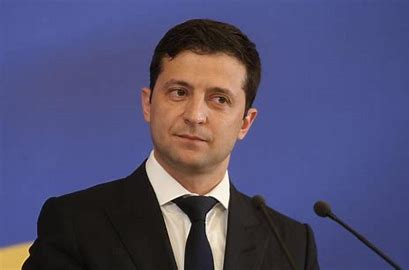

In [2]:
img_name = 'FamousPeopleIMG/1/0.jpg'
# img_name = './img/Britney_Spears_0004.jpg'

image_array = cv2.imread(img_name)
image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
Image.fromarray(image_array)

In [3]:
face_landmarks_list = face_recognition.face_landmarks(image_array, model="large")
face_landmarks_dict = face_landmarks_list[0]
print(face_landmarks_dict, end=" ")

{'chin': [(152, 89), (151, 101), (151, 113), (150, 125), (152, 137), (157, 147), (166, 155), (176, 162), (187, 166), (199, 167), (211, 163), (222, 158), (231, 151), (237, 141), (240, 129), (243, 117), (246, 105)], 'left_eyebrow': [(163, 85), (169, 80), (178, 79), (186, 82), (193, 86)], 'right_eyebrow': [(206, 88), (215, 86), (224, 88), (232, 92), (237, 99)], 'nose_bridge': [(198, 94), (197, 102), (196, 109), (194, 118)], 'nose_tip': [(185, 121), (189, 124), (193, 126), (198, 125), (202, 125)], 'left_eye': [(170, 92), (176, 90), (183, 91), (187, 96), (181, 96), (175, 95)], 'right_eye': [(210, 100), (216, 97), (222, 98), (227, 102), (222, 104), (215, 102)], 'top_lip': [(174, 135), (181, 134), (187, 134), (191, 136), (195, 136), (201, 139), (208, 142), (205, 141), (195, 139), (190, 139), (186, 137), (176, 136)], 'bottom_lip': [(208, 142), (199, 143), (193, 143), (189, 142), (185, 141), (180, 139), (174, 135), (176, 136), (186, 137), (190, 139), (194, 139), (205, 141)]} 

In [4]:
def visualize_landmark(image_array, landmarks):
    """ plot landmarks on image
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return: plots of images with landmarks on
    """
    origin_img = Image.fromarray(image_array)
    draw = ImageDraw.Draw(origin_img)
    for facial_feature in landmarks.keys():
        draw.point(landmarks[facial_feature])
    imshow(origin_img)

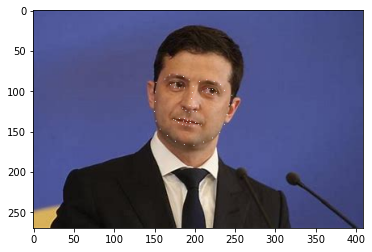

In [5]:
visualize_landmark(image_array=image_array,landmarks=face_landmarks_dict)
plt.show()

In [6]:
def align_face(image_array, landmarks):
    """ align faces according to eyes position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    rotated_img:  numpy array of aligned image
    eye_center: tuple of coordinates for eye center
    angle: degrees of rotation
    """
    # get list landmarks of left and right eye
    left_eye = landmarks['left_eye']
    right_eye = landmarks['right_eye']
    # calculate the mean point of landmarks of left and right eye
    left_eye_center = np.mean(left_eye, axis=0).astype("int")
    right_eye_center = np.mean(right_eye, axis=0).astype("int")
    # compute the angle between the eye centroids
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    # compute angle between the line of 2 centeroids and the horizontal line
    angle = math.atan2(dy, dx) * 180. / math.pi
    # calculate the center of 2 eyes
    eye_center = (int((left_eye_center[0] + right_eye_center[0]) // 2),
                  (int(left_eye_center[1] + right_eye_center[1]) // 2))
    # at the eye_center, rotate the image by the angle
    rotate_matrix = cv2.getRotationMatrix2D(eye_center, angle, scale=1)
    rotated_img = cv2.warpAffine(image_array, rotate_matrix, (image_array.shape[1], image_array.shape[0]))
    return rotated_img, eye_center, angle

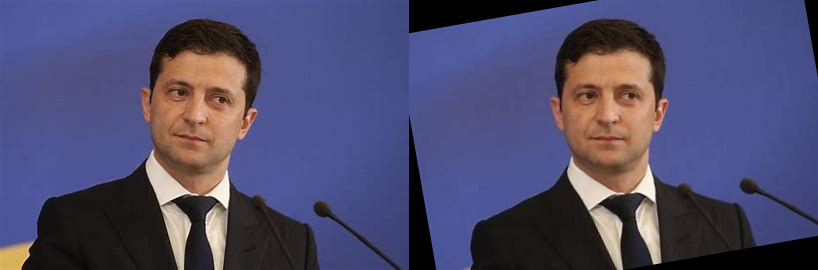

In [7]:
aligned_face, eye_center, angle = align_face(image_array=image_array, landmarks=face_landmarks_dict)
Image.fromarray(np.hstack((image_array,aligned_face)))

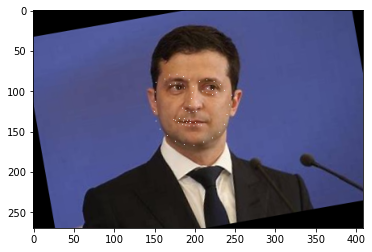

In [8]:
visualize_landmark(image_array=aligned_face,landmarks=face_landmarks_dict)
plt.show()

In [9]:
def rotate(origin, point, angle, row):
    """ rotate coordinates in image coordinate system
    :param origin: tuple of coordinates,the rotation center
    :param point: tuple of coordinates, points to rotate
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated coordinates of point
    """
    x1, y1 = point
    x2, y2 = origin
    y1 = row - y1
    y2 = row - y2
    angle = math.radians(angle)
    x = x2 + math.cos(angle) * (x1 - x2) - math.sin(angle) * (y1 - y2)
    y = y2 + math.sin(angle) * (x1 - x2) + math.cos(angle) * (y1 - y2)
    y = row - y
    return int(x), int(y)

In [10]:
def rotate_landmarks(landmarks, eye_center, angle, row):
    """ rotate landmarks to fit the aligned face
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :param eye_center: tuple of coordinates for eye center
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated_landmarks with the same structure with landmarks, but different values
    """
    rotated_landmarks = defaultdict(list)
    for facial_feature in landmarks.keys():
        for landmark in landmarks[facial_feature]:
            rotated_landmark = rotate(origin=eye_center, point=landmark, angle=angle, row=row)
            rotated_landmarks[facial_feature].append(rotated_landmark)
    return rotated_landmarks

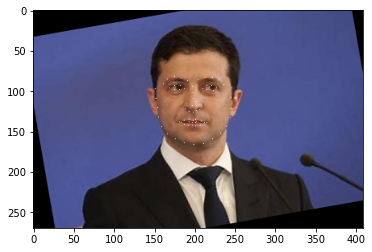

In [11]:
rotated_landmarks = rotate_landmarks(landmarks=face_landmarks_dict,
                                         eye_center=eye_center, angle=angle, row=image_array.shape[0])
visualize_landmark(image_array=aligned_face,landmarks=rotated_landmarks)
plt.show()


In [12]:
def corp_face(image_array, landmarks):
    """ crop face according to eye,mouth and chin position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    cropped_img: numpy array of cropped image
    """

    eye_landmark = np.concatenate([np.array(landmarks['left_eye']),
                                   np.array(landmarks['right_eye'])])
    eye_center = np.mean(eye_landmark, axis=0).astype("int")
    lip_landmark = np.concatenate([np.array(landmarks['top_lip']),
                                   np.array(landmarks['bottom_lip'])])
    lip_center = np.mean(lip_landmark, axis=0).astype("int")
    mid_part = lip_center[1] - eye_center[1]
    top = eye_center[1] - mid_part * 30 / 35
    bottom = lip_center[1] + mid_part

    w = h = bottom - top
    x_min = np.min(landmarks['chin'], axis=0)[0]
    x_max = np.max(landmarks['chin'], axis=0)[0]
    x_center = (x_max - x_min) / 2 + x_min
    left, right = (x_center - w / 2, x_center + w / 2)

    pil_img = Image.fromarray(image_array)
    left, top, right, bottom = [int(i) for i in [left, top, right, bottom]]
    cropped_img = pil_img.crop((left, top, right, bottom))
    cropped_img = np.array(cropped_img)
    return cropped_img,left, top

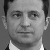

In [13]:
cropped_img,left, top= corp_face(image_array=aligned_face, landmarks=rotated_landmarks)
#print(type(cropped_img))  #<class 'numpy.ndarray'>
cropped_img = cv2.resize(cropped_img, dsize = (50,50), interpolation = cv2.INTER_CUBIC)
img = Image.fromarray(cropped_img)
imgGray = img.convert('L')
imgGray
#imgGray.save(saveFile)

In [14]:
def PreProcess(img_name, size):
    image_array = cv2.imread(img_name)
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    face_landmarks_list = face_recognition.face_landmarks(image_array, model="large")
    face_landmarks_dict = face_landmarks_list[0]
    #visualize_landmark(image_array=image_array,landmarks=face_landmarks_dict)
    aligned_face, eye_center, angle = align_face(image_array=image_array, landmarks=face_landmarks_dict)
    #visualize_landmark(image_array=aligned_face,landmarks=face_landmarks_dict)
    rotated_landmarks = rotate_landmarks(landmarks=face_landmarks_dict,
                                         eye_center=eye_center, angle=angle, row=image_array.shape[0])
    #visualize_landmark(image_array=aligned_face,landmarks=rotated_landmarks)
    cropped_img,left, top= corp_face(image_array=aligned_face, landmarks=rotated_landmarks)
    cropped_img = cv2.resize(cropped_img, dsize = (size,size), interpolation = cv2.INTER_CUBIC)
    img = Image.fromarray(cropped_img)
    imgGray = img.convert('L')
    return imgGray

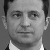

In [15]:
PreProcess('FamousPeopleIMG/1/0.jpg', 50)

In [16]:
nameList = ["肖战", "泽连斯基", "甄子丹", "John Wick", "StarLight", "Lance", "Homelander", "A-Train", "Billy", "Luke Skywalker"]

In [17]:
import os
cnt = 0
for i in range(10):
    files = os.listdir("FamousPeopleIMG/" + str(i) + "/")
    for f in files:
        path = "FamousPeopleIMG/" + str(i) + "/"+f
        #print(path)
        imgGray = PreProcess(path, 50)
        saveFile = "DataProcessed_Famous/train/" + str(cnt) + ".jpg"
        cnt = cnt + 1
        imgGray.save(saveFile)
    print(nameList[i] + ": FamousPeopleIMG/" + str(i) + "/" + "处理完成！")
print("训练数据处理完成！")
        
i = 0
files = os.listdir("FamousPeopleIMG//test/")
for f in files:
    path = "FamousPeopleIMG//test/"+f
    imgGray = PreProcess(path, 50)
    saveFile = "DataProcessed_Famous/test/" + str(i) + ".jpg"
    i = i + 1
    imgGray.save(saveFile)
print("测试数据处理完成")

肖战: FamousPeopleIMG/0/处理完成！
泽连斯基: FamousPeopleIMG/1/处理完成！
甄子丹: FamousPeopleIMG/2/处理完成！
John Wick: FamousPeopleIMG/3/处理完成！
StarLight: FamousPeopleIMG/4/处理完成！
Lance: FamousPeopleIMG/5/处理完成！
Homelander: FamousPeopleIMG/6/处理完成！
A-Train: FamousPeopleIMG/7/处理完成！
Billy: FamousPeopleIMG/8/处理完成！
Luke Skywalker: FamousPeopleIMG/9/处理完成！
训练数据处理完成！
测试数据处理完成


In [20]:
#观察到训练数据已经是人脸了，因此只要简单的转化为灰度图
import os
from PIL import Image,ImageDraw
files = os.listdir("StudentIMG/train/")
cnt = 0
for f in files:
    path = "StudentIMG/train/" + f
    saveFile = "DataProcessed_Student/train/" + str(cnt) + ".jpg"
    cnt += 1
    img = Image.open(path)
    img = img.resize((50, 50))
    imgGray = img.convert('L')
    imgGray.save(saveFile)
print("训练数据处理完成")

训练数据处理完成


In [19]:
#观察到测试数据中，41011.jpg、41012.jpg、41013.jpg这三张图片需要裁剪人脸
#其他图片转化为灰度图即可
#观察到训练数据已经是人脸了，因此只要简单的转化为灰度图
import os
from PIL import Image,ImageDraw
files = os.listdir("StudentIMG/test/")
cnt = 0
specialName = ["41011.jpg", "41012.jpg", "41013.jpg"]
for f in files:
    if(f in specialName): #特殊图片不能直接灰度图，需要先裁剪
        continue
    path = "StudentIMG/test/" + f
    saveFile = "DataProcessed_Student/test/" + str(cnt) + ".jpg"
    cnt += 1
    img = Image.open(path)
    img = img.resize((50, 50))
    imgGray = img.convert('L')
    imgGray.save(saveFile)
for f in specialName:
    imgGray = PreProcess("StudentIMG/test/" + f, 50)
    saveFile = "DataProcessed_Student/test/" + str(cnt) + ".jpg"
    cnt += 1
    imgGray.save(saveFile)
print("测试数据处理完成")

测试数据处理完成
